# Reward Model Training

```
Author: Ehsan Kamalinejad (EK)
Created: 2023-08-23
```

In this notebook we follow [Instruct GPT paper](https://arxiv.org/abs/2203.02155) (the predecessor to chatGPT) to train a reward model. This reward model can be used in RLHF or other reward based training methods (such as [ReST](https://arxiv.org/abs/2308.08998)). Also, as explained in the lecture 3, one can train their own reward model as a customized benchmark.

Notes about the dataset:
- We use IMDb dataset here because of simplicity, but you can use any other dataset or bring your own dataset. The process remains unchanged and there is even a cell (commented out) for preprocessing any other dataset into the format we need.
- In order to train your reward model, you will need a dataset ranked by human preferences. For IMDd, we use positive sentiment as the preference axis, meaning a positive review is considered to have ranked higher than a negative review.
- In most of datasets, each sample has two parts: a query and its response. The ranking is based on the responses that the humans prefer. Here, we have an empty query and the response preference is its sentiment. Note that this is only for simplicity and the training remains unchanged if you have a query-response dataset.
- At the end of the training, the model provides a higher score for text which humans preferred. In IMDb case, the model assigns higher score to positive reviews and a lower score for negative reviews.

### 0. Requirements

In [ ]:
%%writefile requirements.txt
transformers
datasets
accelerate
omegaconf
torchtyping
ipywidgets
matplotlib

Writing requirements.txt


In [ ]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 

Now restart your kernel and continue.

### 1. Import libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pylab as plt
from omegaconf import DictConfig

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import Dataset, load_dataset

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    set_seed,
)

### 2. Settings

In [ ]:
args = {
    "seed": 42,
    'model_name_or_path': 'facebook/opt-350m',
    'learning_rate': 5e-5,
    'batch_size': 2,
    'gradient_accumulation_steps': 16,
    'num_train_epochs': 1,
    'num_workers': 10,
    'seq_length': 1024,
    'logging_steps': 10,
}

args = DictConfig(args)

set_seed(args.seed)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path)
if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

### 3. Data Preparation

- Use the `Ranked Query-Response Format` cell if your dataset is already in the ranked query-response format (for example `Anthropic/hh-rlhf`) which has `chosen` and `rejected` columns.
- Or follow the second cell to create a custom dataset. You will need to change it according to your dataset. Here, case we pair positive and negative samples according to IMDb sentiment.

In [ ]:
# # Ranked Query-Response Format

# raw_dataset = load_dataset("Anthropic/hh-rlhf")
# train_dataset = raw_dataset['train']


# def tokenize_fn(text, max_length=args.seq_length):
#     encoded = tokenizer(
#         text,
#         padding='max_length',
#         max_length=max_length,
#         truncation=True,
#         add_special_tokens=False,
#     )
#     return encoded


# def encode(sample):
#     chosen_encoded = tokenize_fn(sample['chosen'])
#     rejected_encoded = tokenize_fn(sample['rejected'])
#     encoded = {
#         'chosen_input_ids':chosen_encoded['input_ids'],
#         'chosen_attention_mask':chosen_encoded['attention_mask'],
#         'rejected_input_ids':rejected_encoded['input_ids'],
#         'rejected_attention_mask':rejected_encoded['attention_mask'],
#     }
#     return encoded


# train_dataset = train_dataset.shuffle().map(encode, num_proc=args.num_workers)

# train_dataset = train_dataset.with_format("torch")

# train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)

In [ ]:
# Response-only Format

def create_custom_dataset(raw_dataset):
    df = raw_dataset.to_pandas()
    negative_df = df[df['label']==0]
    positive_df = df[df['label']==1]
    negative_df = negative_df.drop(
        columns=['label']).rename(
        columns={'text': 'rejected'})
    # shuffle the data
    positive_df = positive_df.sample(
        frac=1, random_state=0).reset_index(
        drop=True).drop(columns=['label']).rename(
        columns={'text': 'chosen'})
    joined_df = negative_df.join(positive_df)

    def tokenize_fn(texts, max_length=args.seq_length):
        encoded = tokenizer(
            texts,
            padding='max_length',
            max_length=max_length,
            truncation=True,
            add_special_tokens=False,
        )
        return encoded

    rejected_encoded = tokenize_fn(joined_df.rejected.values.tolist())
    joined_df['rejected_input_ids'] = rejected_encoded['input_ids']
    joined_df['rejected_attention_mask'] = rejected_encoded['attention_mask']
    encoded_chosen = tokenize_fn(joined_df.chosen.values.tolist())
    joined_df['chosen_input_ids'] = encoded_chosen['input_ids']
    joined_df['chosen_attention_mask'] = encoded_chosen['attention_mask']

    train_dataset = Dataset.from_pandas(joined_df, preserve_index=False)

    return train_dataset.with_format("torch")

In [ ]:
raw_dataset = load_dataset("imdb")
del raw_dataset['unsupervised']

train_dataset = create_custom_dataset(raw_dataset['train'])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### 4. Model

Notes about the model:
- For a reward modeling, you will need to have a scalar reward head on top of your model. This head will return logits. Options:
    1. You can use any language model such as the class `AutoModelForCausalLM` model and then create a custom reward head on top of it (as shown in the commented out cell). This gives you the flexibility of working with any model you like.
    2. Or you can use `AutoModelForSequenceClassification` which creates a scalar head on top of your base causal model and it supports most of the popular models in HuggingFace.
- Here we use `device_map="auto"` argument to allow your model to be distributed over your devices (GPUs/TPUs). You can comment this out if you have one device or your drivers/GPUs are older.
- We use `torch_dtype=torch.bfloat16` 16-bit floating-point format which has lower memory footprint without significantly degrading performance. This is supported for newer CUDA drivers only. If your machine does not support it, comment this out.

In [ ]:
# class CLMRewardHead(nn.Module):
#     def __init__(self, base_model):
#         super(CLMRewardHead, self).__init__()
#         self.base_model = base_model
#         self.device = self.base_model.device
#         n_embd = self.base_model.config.hidden_size
#         self.reward_head = nn.Sequential(
#                 nn.LayerNorm(n_embd),
#                 nn.GELU(),
#                 nn.Linear(n_embd, 4*n_embd),
#                 nn.GELU(),
#                 nn.Linear(4*n_embd, 1),
#             ).to(torch.bfloat16).to(self.device)

#     def forward(self, input_ids, attention_mask=None):
#         outputs = self.base_model(
#             input_ids,
#             attention_mask=attention_mask,
#             output_hidden_states=True)
#         last_hidden_state = outputs.hidden_states[-1]
#         last_hidden_state_mean = torch.mean(last_hidden_state, 1)
#         last_hidden_state_mean = last_hidden_state_mean.to(torch.bfloat16)
#         logits = self.reward_head(last_hidden_state_mean)
#         return logits

# base_model = AutoModelForCausalLM.from_pretrained(
#     args.model_name_or_path,
#     torch_dtype=torch.bfloat16,
#     device_map="auto",
# )

# model = CLMRewardHead(base_model)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    args.model_name_or_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    num_labels=1,
)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5. Training

One can use HuggingFace `Trainer` function to train the model here. But then you will need to create a [custom loss](https://huggingface.co/transformers/v4.0.1/main_classes/trainer.html). Here we use a vanilla PyTorch training loop so that we see all the details clearly.

We also implement a `gradient_accumulation_steps` so that we can go with a batch size of 1 to save memory and keeping the same effect as having a larger effective batch size (defined by `accumulation x batch_size`). If your machine allows for larger batch sizes, use it as it can speed up the process.

In [ ]:
epoch = 1
print_interval=args.logging_steps
num_batches = len(train_dataloader)
progress_bar = tqdm(total=num_batches*args.num_train_epochs, leave=True)
progress_bar.set_description(f"| Train: Epoch {epoch}, evaluating ... |")
losses = []
temp_losses = []
i = 0


optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)


for epoch in range(1, args.num_train_epochs+1):

    for batch in train_dataloader:

        chosen_input_ids = batch['chosen_input_ids'].to(model.device)
        chosen_attention_mask = batch['chosen_attention_mask'].to(model.device)
        rejected_input_ids = batch['rejected_input_ids'].to(model.device)
        rejected_attention_mask = batch['rejected_attention_mask'].to(model.device)

        r_w = model(chosen_input_ids, attention_mask=chosen_attention_mask).logits
        r_l = model(rejected_input_ids, attention_mask=rejected_attention_mask).logits

        loss = -F.logsigmoid(r_w - r_l).mean()

        # Accumulate the gradients
        loss /= args.gradient_accumulation_steps
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if (i + 1) % args.gradient_accumulation_steps == 0 or i + 1 == len(train_dataloader):
            optimizer.step()
            optimizer.zero_grad()

        temp_losses.append( loss.item() )
        if i%print_interval==0:
            progress_bar.set_description(f"| Train: Epoch {epoch}, loss = {loss.item():4f} |")
            progress_bar.refresh()
            losses.append( np.mean(temp_losses) )
            temp_losses = []
        progress_bar.update()
        i+=1


progress_bar.set_description(f"| Train: Epoch {epoch}, loss = {loss.item():4f} |")
progress_bar.refresh()

  0%|          | 0/6250 [00:00<?, ?it/s]

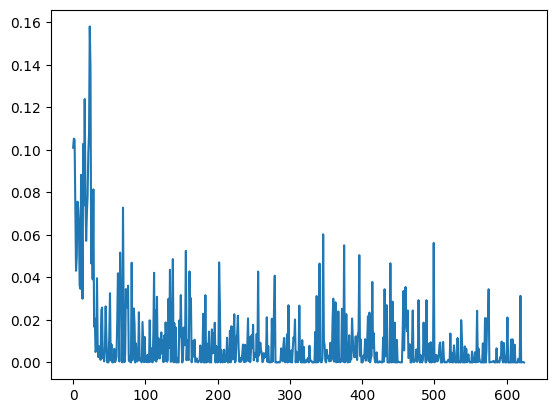

In [ ]:
plt.plot(losses);

### 6. Evaluation

In [ ]:
model = model.eval()

In [ ]:
# # Ranked Query-Response Format

# test_dataset = raw_dataset['test']
# test_dataset = test_dataset.map(encode, num_proc=args.num_workers)
# test_dataset = test_dataset.with_format("torch")
# test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size)

In [ ]:
# Response-only Format

test_dataset = create_custom_dataset(raw_dataset['test'])
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size)

In [ ]:
num_correct_orders = 0

with torch.no_grad():

    for batch in tqdm(test_dataloader):

        chosen_input_ids = batch['chosen_input_ids'].to(model.device)
        chosen_attention_mask = batch['chosen_attention_mask'].to(model.device)
        rejected_input_ids = batch['rejected_input_ids'].to(model.device)
        rejected_attention_mask = batch['rejected_attention_mask'].to(model.device)

        r_w = model(chosen_input_ids, attention_mask=chosen_attention_mask).logits
        r_l = model(rejected_input_ids, attention_mask=rejected_attention_mask).logits

        num_correct_orders += (r_w - r_l>0).sum().item()

print('Accuracy of orders after training: ', num_correct_orders/(len(test_dataloader)*args.batch_size))

  0%|          | 0/6250 [00:00<?, ?it/s]

Accuracy of orders after training:  0.98128


### 7. Save

In [ ]:
path = './reward/reward_model'
model.save_pretrained(path)